In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
import pickle
from sklearn import preprocessing
from sklearn import svm
import pandas as pd
from scipy.stats import kendalltau
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy
from scipy.stats import spearmanr
from collections import defaultdict
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
import time
from ensemble_utils import Ensemble

In [2]:
X_train, y_train, X_test, y_test = pickle.load(open('Data/adult_income/processed_data.pkl', 'rb'))

# Ensembles

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
versions = ['MLP Ensemble', 'RF Ensemble', 'LogReg Ensemble', 'SVM Ensemble', 'All Ensemble']
params={'rf_num':100, 'mlp_num': 2, 'svm_num': 2, 'lr_num': 2}
mega_predictions = []
mega_agg_predictions = []
for i in range(len(versions)):
    print("-----Type: {0}-------".format(versions[i]))
    model = Ensemble(version=i, params=params)
    model.train(X_train, y_train)
    all_predictions = model.test(X_test)
    all_accuracies = [accuracy_score(y_test, all_predictions[:, i]) for i in range(len(all_predictions[0]))]
    agg_predictions = model.test_agg(X_test)
    
    mega_predictions.append(all_predictions)
    mega_agg_predictions.append(agg_predictions)

    print("Overall accuracy: {0}, individual average accuracy: {1}".format(accuracy_score(y_test, agg_predictions), np.mean(all_accuracies)))


-----Type: MLP Ensemble-------
Overall accuracy: 0.8339309428950863, individual average accuracy: 0.8281208499335989
-----Type: RF Ensemble-------
Overall accuracy: 0.8479415670650731, individual average accuracy: 0.799778220451527
-----Type: LogReg Ensemble-------
Overall accuracy: 0.8029216467463479, individual average accuracy: 0.8031208499335989
-----Type: SVM Ensemble-------
Overall accuracy: 0.800464807436919, individual average accuracy: 0.7880810092961488
-----Type: All Ensemble-------
Fitted model type 0 of 4
Fitted model type 1 of 4
Fitted model type 2 of 4
Fitted model type 3 of 4
Overall accuracy: 0.8122841965471448, individual average accuracy: 0.7988304643062968


# Investigating what is a shared trait amongst those most likely to be wrong

In [13]:
print(mega_predictions[0].shape)

(15060, 2)


Wrong distribution for MLP Ensemble


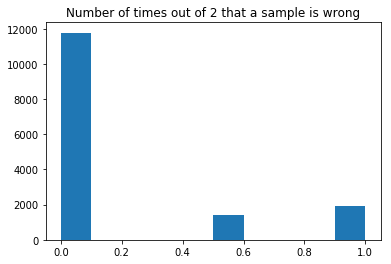

Wrong distribution for RF Ensemble


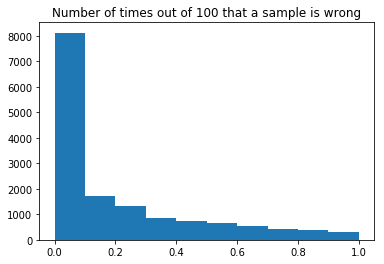

Wrong distribution for LogReg Ensemble


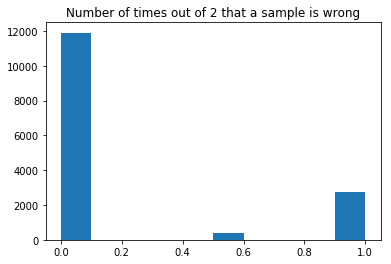

Wrong distribution for SVM Ensemble


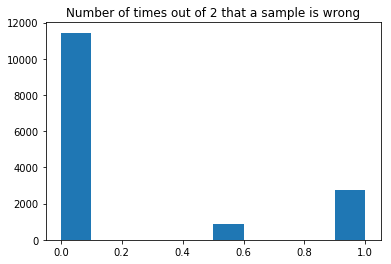

Wrong distribution for All Ensemble


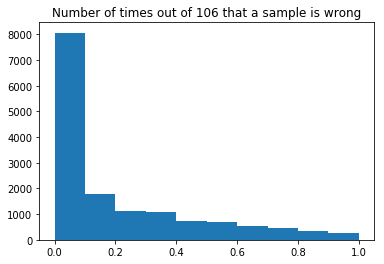

In [29]:
mega_wrongs = []
for i in range(len(mega_agg_predictions)):
    print("Wrong distribution for {0}".format(versions[i]))
    num_wrongs = np.zeros(len(y_test))
    predictions = mega_predictions[i]
    for j in range(len(predictions[0])):
        wrongs = np.array(y_test!=predictions[:, j])
        num_wrongs += wrongs

    num_wrongs = np.array(num_wrongs) / len(predictions[0])
    mega_wrongs.append(num_wrongs)
    plt.hist(num_wrongs)

    plt.title('Number of times out of {} that a sample is wrong'.format(len(predictions[0])))
    plt.show()
    plt.close()

In [30]:
from scipy.spatial.distance import cdist
mega_sorted_wrongs = np.array([np.argsort(mega_wrong) for mega_wrong in mega_wrongs])
kendalltau_mat = cdist(mega_sorted_wrongs, mega_sorted_wrongs, metric='correlation')

In [31]:
# to compare correlation of errors
print(kendalltau_mat)

[[0.         1.01062061 0.23096336 0.27053099 1.0093958 ]
 [1.01062061 0.         1.01433694 1.01048627 0.98282004]
 [0.23096336 1.01433694 0.         0.28036863 1.01448155]
 [0.27053099 1.01048627 0.28036863 0.         1.01462478]
 [1.0093958  0.98282004 1.01448155 1.01462478 0.        ]]


In [32]:
kendalltau(mega_wrongs[0], mega_wrongs[1])

KendalltauResult(correlation=0.5331491593700642, pvalue=0.0)

In [ ]:
# dists = []
# sorted_mlp = list(np.argsort(num_wrongs))
# sorted_rf = list(np.argsort(num_rf_wrongs))
# for i in range(len(num_wrongs)):
#     dists.append(sorted_mlp.index(i) - sorted_rf.index(i))
# dists = np.absolute(dists)

(array([5831., 3180., 1914., 1742., 1129.,  764.,  341.,  110.,   41.,
           8.]),
 array([0.        , 0.09575033, 0.19150066, 0.287251  , 0.38300133,
        0.47875166, 0.57450199, 0.67025232, 0.76600266, 0.86175299,
        0.95750332]),
 <a list of 10 Patch objects>)

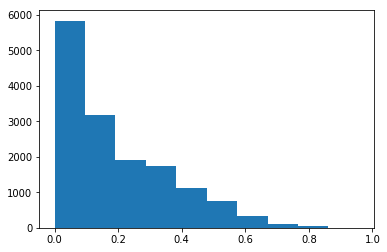

In [25]:
# dists = np.array(dists) / len(num_wrongs)
# plt.hist(dists)

------MLP Ensemble-----
R^2 score: 0.15902626116231733


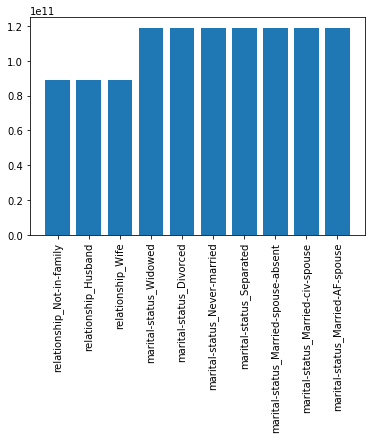

------RF Ensemble-----
R^2 score: 0.3256554093906656


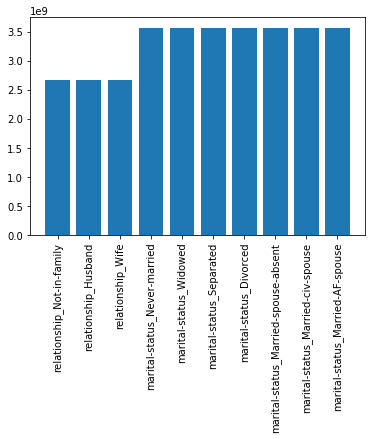

------LogReg Ensemble-----
R^2 score: 0.18577404148293275


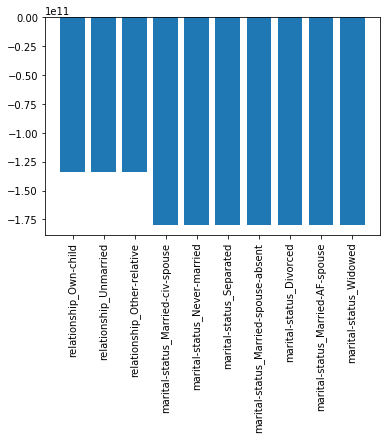

------SVM Ensemble-----
R^2 score: 0.206777015904272


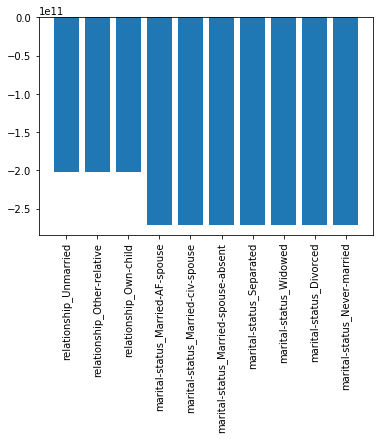

------All Ensemble-----
R^2 score: 0.3374223006951518


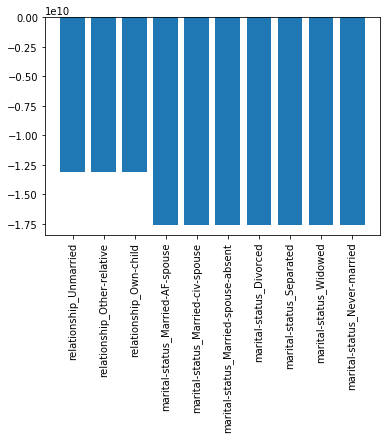

In [34]:
for i in range(len(versions)):
    print("------{}-----".format(versions[i]))
    model = LinearRegression()
    model.fit(X_test, mega_wrongs[i])
    importance = model.coef_
    print("R^2 score: {}".format(model.score(X_test, mega_wrongs[i])))

    most_important = np.argsort(np.absolute(importance))[-10:]
    plt.bar(np.array(X_train.keys())[most_important], np.array(importance)[most_important])
    plt.xticks(rotation='vertical')
    plt.show()
    plt.close()

In [ ]:
model = svm.SVR()

model.fit(X_test, num_wrongs)
print("R^2 score: {}".format(model.score(X_test, num_wrongs)))

importance = permutation_importance(model, X_test, num_wrongs).importances_mean

most_important = np.argsort(np.absolute(importance))[-10:]
plt.bar(np.array(X_train.keys())[most_important], np.array(importance)[most_important])
plt.xticks(rotation='vertical')
plt.show()

## Getting rid of collinear features

In [30]:
corr = spearmanr(X_train).correlation
corr_linkage = hierarchy.ward(corr)
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
# selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

selected_features = []
for v in cluster_id_to_feature_ids.values():
    if len(v) > 1:
        print("Retained only one of {}".format([list(X_train.keys())[ind] for ind in v]))
    selected_features.append(v[0])

X_train_sel = X_train.iloc[:, selected_features]
X_test_sel = X_test.iloc[:, selected_features]

clf_sel = RandomForestClassifier()
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

Retained only one of ['marital-status_Married-civ-spouse', 'relationship_Husband']
Accuracy on test data with features removed: 0.85
